<a href="https://colab.research.google.com/github/SeongwonTak/PythonProjects/blob/master/CarPriceProject_1stTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Used_Car Project_첫번째 시도

2021.1.10~2021.1.17

현재 Data Diving 8기 주말반 수업을 들으면서 여러 내용을 배우고 있고, 혼자 독학으로

- 머신러닝 교과서
- 데이터 사이언스 스쿨
- 밑바닥부터 시작하는 데이터 과학

등을 참조하며, 데이터 사이언스 공부를 진행중이다.

무언가, 지금까지 배운 내용을 토대로 독학을 하면서 하나의 내용이라도 알고 복습을 하는 것이 좋다고 판단하여, 간단한 side project를 진행해보려고 한다.

## 기본 준비

In [1]:
# 패키지를 먼저 import 한다. 추가로 필요한 패키지는 그때그때.
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


풀려는 문제의 링크는 다음과 같다.

https://www.kaggle.com/avikasliwal/used-cars-price-prediction


문제는 간단하다.
**주어진 자동차의 이름, 위치, 년식, 운전거리, 연료타입 등등을 바탕으로 중고차의 가격을 예측하는 것이다.**


훈련 데이터에 나온 변수들의 역할부터 파악한다.

---

1) Name : 자동차의 브랜드와 모델명

2) Location : 자동차가 팔린 곳 or 구입 가능한 장소

3) Year : 자동차가 몇년도에 생산된건지.

4) Kilometers_Driven : 이전 운전자들에 의해 운전된 총 운전거리

5) Fuel_Type : 연료의 종류

6) Transmission : Auto인가? Manual인가?

7) Owner_Type : Kaggle에 변수에 대한 설명이 없다... ㅡㅡ 앞에 주인이 몇명인지로 보인다.

8) Mileage : 단위를 보아하니 연비

9) Engine : 배기량이 어느정도인가?

10) Power : bhp라는 단위가 보이는데, 뭔지 모르겠어서 찾아본 결과 제동 마력, 일반적인 출력 엔진을 뜻한다고 한다.

11) Seats : 자리개수는 몇개인가?

12) New_Price : ???. 대체 이게 무엇인고...근데 거의 다 결측이라 크게 의미는 없어보인다.

13 ) Price : 목표변수. 앞 변수들로 이것을 계산해야 한다. 수치형 데이터로 가격을 맞춰야 하므로 이건 회귀 문제다.

In [ ]:
# excel로 data를 불러와서 데이터의 전체적인 상황을 파악하자.
dummy_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/usedcar_project/usedcar_train_data.csv')
dummy_data

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,6014,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.4 kmpl,1248 CC,74 bhp,5.0,7.88 Lakh,4.75
6015,6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.4 kmpl,1120 CC,71 bhp,5.0,NaN,4.00
6016,6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.0 kmpl,2498 CC,112 bhp,8.0,NaN,2.90
6017,6017,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.9 kmpl,998 CC,67.1 bhp,5.0,NaN,2.65


내용을 이렇게 살펴 본 결과 **당장 하고 싶은 일이 몇 가지 생긴다.**

(1) 결과 목표값과 데이터 필드를 분리하여 저장하되

(2) 앞의 index는 제거를 해버리고 싶고

(3) 딱보도 결측치가 엄청 많아 보이는 New_Price는 판단의 근거가 될 수 없다고 판단, 실제로 결측치가 몇개인지 확인 후에 New_Price를 제거한다.

(4) 그 후 수치형 변수와 범주형 변수를 분류한다.

In [2]:
# Step 0-1. Index를 날려버린다. 엑셀로 초기 검토 과정에서 애초에 이걸 해버리는 편이 좋을 거 같다....
dummy_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/usedcar_project/usedcar_train_data.csv', index_col=0)

# Step 0-2. 결측치가 몇개인지 세보자.
dummy_data.isnull().sum()
# 6015개인데.. New_Price가 5195개나 Null??? 분석 data에 의미가 없어보인다. DROP.
dummy_data=dummy_data.drop('New_Price', axis=1)

**dfX**의 수치형변수 / 범주형변수 를 구분하고자 한다.
- 수치형 : Year, KIlometers_Driven, Mileage, Engine,
Power, Seats, Price. **Owner_Type**

- 범주형 : Name, Location, Fuel_Type, Transmission

주의사항, Owner_Type은 정의상 몇번째 Owner이므로, 수치적으로 표현해야 한다. 따라서 이를 변형해야 할 것이다. 이는 변수별 전처리 작업에서 진행하고자 한다.

In [ ]:
이제 해야 하는 일은

1) 결측치를 확인하여 결측치 관리를 한다.

2) Owner_Type을 수치 데이터로 변형하다.

3) 수치 데이터와, Price의 상관관계, 혹은 각각의 상관관계를 본다.
  이는 Heatmap을 활용하여 본다.

4) 시각화를 통해 우선적으로 각각의 분포를 점검한다.
이는 sns의 pairplot을 활용한다.

In [ ]:
# Step 1. 결측치 관리
# Step 1-1. 다시 한 번 결측치가 몇개 있나 테스트
dummy_data.isnull().sum()

# Step 1-2. 통계치를 정리해보자. 현 상태로 수치형 값 먼저.
dummy_data.describe()

# Step 1-3. 이 수치형 값들의 관계를 pairplot으로 보자.
# sns.pairplot(dummy_data)

# Step 1-4. Heatmap을 통해 상관관계 값을 구체적으로 보자.
# sns.heatmap(dummy_data) 를 하려하니, Numerical만 뽑아야 한다.
# 단위 제거를 해야 하는데.. 어떻게?
dummy_data_numerical = dummy_data.loc[:,["Year", "Kilometers_Driven", "Seats", "Price"]]
dummy_data_numerical.corr()

# 흠..? 각각으로는 예상보다 상관관계가 낮음을 알 수 있다.


,Year,Kilometers_Driven,Seats,Price
Year,1.000000,-0.173048,0.012333,0.305327
Kilometers_Driven,-0.173048,1.000000,0.083113,-0.011493
Seats,0.012333,0.083113,1.000000,0.052225
Price,0.305327,-0.011493,0.052225,1.000000


sns.pairplot 작업과 corr 작업을 통해 몇 가지 문제 상황 및 insight(?)을 발견했다.

(1) Year, Kilometers_Driven, Seat 만으로는 Price와의 상과나관계가 0.3 이하 로 매우 낮음을 알 수 있다. **다른 요소가 Price**에 큰 영향을 주고 있음을 알 수 있다.

(2) 일부 데이터에 대해 다시 전처리 작업을 진행해야 한다. 수치형 데이터에 단위가 붙어버리는 순간, char로 인식하는 것으로 추정된다. 이에 대한 제거와 함께 price와의 corr을 다시 봐야 한다.

(3) pairplot을 통해 Kilometers_Driven의 히스토그램을 본 결과, 이것에서 무언가 황당한 결측치가 있는 것으로 보인다. 제거를 할 필요가 있어보인다.

(4) price 자체는 작은 값에 매우 몰려 있는 상태이다. 다시 말해 Log scale을 사용후 정규분포 변환을 통해 값을 조정할 필요가 있어 보인다.

## 변수별 전처리

변수별로 전처리 작업을 진행하고자 한다. 해야하는 과정은

(1) 결측치 확인 및 결측치 채우기/제거

(2) 시각화를 통한 분포 점검 및 scaling 실시

In [ ]:
dummy_data.isnull().sum()
# Mileage, Engine, Power, Seats는 결측치를 채워거나 확인해야 한다.

Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

In [3]:
# Name 
# sns.countplot(x = 'Name', data = dummy_data)을 했더니.... 도저히 밑을 알아볼 수가 없어서. 시각화는 용이하지 않다.
# dummy_data.groupby('Name').count()   # 를 해서 종류별로 묶었더니, 1876종류가 나와버린다.

# cvs 파일에서 직접 확인해 본 결과, 첫 어절 로 데이터를 변형하면 괜찮을거 같다.
for i in range(len(dummy_data['Name'])):
  dummy_data.loc[i,'Name'] = dummy_data.loc[i,'Name'].split()[0]

Name 변수에 대해서 간단히 본 결과, 하나씩만 있는것도 있어서 표본의 대표성을 주긴 아쉽지만... 그래도 이정도면 어느정도 그룹화가 되어 당장은 충분해보인다.

이후에 가볼 방향성이라면, **다른 요소가 모두 같다고 가정, Price의 평균값을 매겨 Brand의 랭크를 매겨볼 생각이다.**

이를 위해서는 brand 를 제외한 상황에서의 어느정도의 회귀 직선을 찾은 후 군집 특성에 맞게 y축 이동시켜볼 생각이다. 보통, 차량의 브랜드 값 / 국가 값을 제외하면 나머지 변수는 동일할거니까. 

Location에 대해서는 결측치도 없어보이거니와, 당장 크게 문제가 없어보이므로 일단은 넘어가보자.

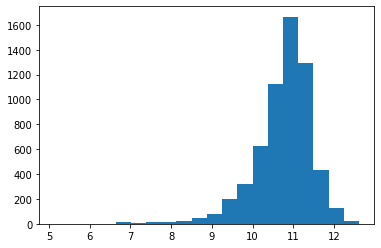

In [4]:
# Kilometers_Driven 변수 처리
# 무언가 아까, 이상한 점을 보았기에 summary부터.
# dummy_data.loc[:,'Kilometers_Driven'].describe()

# 히스토그램을 그려서 결과를 보려고 했는데 너무 큰 값 때문인지, 제거를 해야할 거 같다.
# cvs를 통해 확인한 결과.. drop을 해야할거 같다.
# dummy_data = dummy_data.loc[dummy_data['Kilometers_Driven']!=6500000,:]

# 이렇게 보니까 다시 또 보이는데 먼저, 40만 초과는 drop으로 outlier 처리.
# 그 후 다시 그려서, log scale 변환을 시켜버리자.

# 아래 두 행은 재실행시 꼭 반드시 주석을 풀어주자.

dummy_data = dummy_data.loc[dummy_data['Kilometers_Driven']<=400000,:]

dummy_data.loc[:,'Kilometers_Driven'] = dummy_data.loc[:,'Kilometers_Driven'].map(np.log)

plt.hist(dummy_data.loc[:,'Kilometers_Driven'], bins=20)
plt.show()


이렇게 해도 우측으로 치우친 감이 없잖아 있으나, 그냥 놔두려는 이유는 1000km, 2000km도 안 탄 신형차의 경우는 '감가상각' 자체가 덜 일어났음을 알 수 있기 때문에, 이것에 대해서 굳이 변형하려고 하지 않는다. 무시할 수 없는 변수이다. 반면, 감가상각의 특성상 연수가 탄 km수가 크다면, 오래 탔다는 것이므로 감가상각의 효과는 줄어들 것이다. 따라서 큰 km수에 대해서의 결측치는 제거해도 무방하다.

In [5]:
# Year
# 간단하다. (Max - 값으로 변형하자.)
# describe를 통해 2019가 최대임을 아므로,

dummy_data.loc[:,'Year'] = dummy_data.loc[:,'Year'].map(lambda x : 2020-x)
dummy_data.tail()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
6014,Maruti,Delhi,6,10.217020,Diesel,Manual,First,28.4 kmpl,1248 CC,74 bhp,5.0,4.75
6015,Hyundai,Jaipur,5,11.512925,Diesel,Manual,First,24.4 kmpl,1120 CC,71 bhp,5.0,4.00
6016,Mahindra,Jaipur,8,10.915088,Diesel,Manual,Second,14.0 kmpl,2498 CC,112 bhp,8.0,2.90
6017,Maruti,Kolkata,7,10.736397,Petrol,Manual,First,18.9 kmpl,998 CC,67.1 bhp,5.0,2.65
6018,Chevrolet,Hyderabad,9,10.757903,Diesel,Manual,First,25.44 kmpl,936 CC,57.6 bhp,5.0,2.50


분명히 최대는 2019인데 2020에서 뺀 이유는, 회귀분석시 0의 값에 의해 계수가 날라갈 수 있는 사태를 막으려고 한다.

또한, 굳이 Min-Max Scaling이 아니라, Max에서 뺀 이유는 중고차 시장에서의 감가상각(?)의 효과가 크다는 것을 알고 이를 수치적으로 극대화 시키기 위해 건드리지 않았다.

In [6]:
# Engine
# 단위 제거부터.
df = dummy_data
df = df.reset_index()
df = df.drop('index', axis = 1)
 
 
for i in range(len(df['Engine'])):
  if type(df.loc[i,'Engine']) == str :
    df.loc[i,'Engine'] = int(df.loc[i,'Engine'].split()[0])
 
average = df.loc[:,'Engine'].mean()
average
 
# 채운다, 평균으로ㅡ
df.loc[:,'Engine'] = df.loc[:,'Engine'].fillna(1621.1)
 
dummy_data = df
dummy_data.isnull().sum()

Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine                0
Power                36
Seats                42
Price                 0
dtype: int64

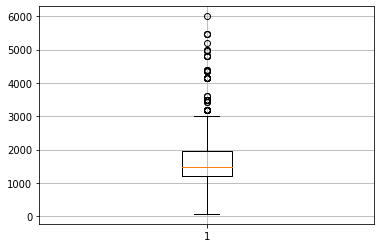

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
5946,Maruti,Delhi,6,10.217020,Diesel,Manual,First,28.4 kmpl,1248.0,74 bhp,5.0,4.75
5947,Hyundai,Jaipur,5,11.512925,Diesel,Manual,First,24.4 kmpl,1120.0,71 bhp,5.0,4.00
5948,Mahindra,Jaipur,8,10.915088,Diesel,Manual,Second,14.0 kmpl,2498.0,112 bhp,8.0,2.90
5949,Maruti,Kolkata,7,10.736397,Petrol,Manual,First,18.9 kmpl,998.0,67.1 bhp,5.0,2.65
5950,Chevrolet,Hyderabad,9,10.757903,Diesel,Manual,First,25.44 kmpl,936.0,57.6 bhp,5.0,2.50


In [7]:
# outlier 확인 및 제거작업.
plt.boxplot(dummy_data.loc[:,'Engine'])
plt.grid()
plt.show()

dummy_data = dummy_data.loc[dummy_data['Engine']<=3000,:]
dummy_data = dummy_data.reset_index()
dummy_data = dummy_data.drop('index', axis = 1)
dummy_data.tail()

In [8]:
# Seats
dummy_data.loc[:,'Seats'].value_counts()

# 최빈값 확인 결과 5,
# 결측값을 최빈값으로 넣을려고 한다.
dummy_data.loc[:,'Seats'] = dummy_data.loc[:,'Seats'].fillna(5)
dummy_data.isnull().sum()

Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine                0
Power                36
Seats                 0
Price                 0
dtype: int64

In [9]:
# Power
# 단위 제거부터.
# cvs로 다시 탐색을 해보니 null bhp라는 추가 결측치가 발견.
df = dummy_data
df = df.reset_index()
df = df.drop('index', axis = 1)

print(type(df.loc[0,'Power']))
 
for i in range(len(df['Power'])):
  if df.loc[i, 'Power'] == 'null bhp':
    df.loc[i, 'Power'] = np.nan

  elif type(df.loc[i,'Power']) == str :
    df.loc[i,'Power'] = float(df.loc[i,'Power'].split()[0])
 
average = df.loc[:,'Power'].mean()
average

dummy_data = df

dummy_data.loc[:,'Power'] = dummy_data.loc[:,'Power'].fillna(113.25)

<class 'str'>


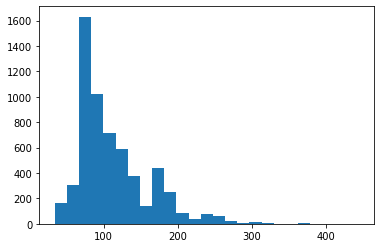

In [10]:

#  분포 점검.
plt.hist(dummy_data.loc[:,'Power'], bins=25)
plt.show()

# 좌측 위주로 많이 쏠렸다.
# 로그변환 후, 값을 변환.
dummy_data.loc[:,'Power'] = dummy_data.loc[:,'Power'].map(np.log)

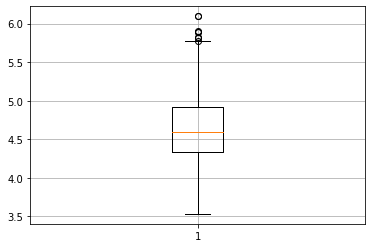

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
5939,Maruti,Delhi,6,10.217020,Diesel,Manual,First,28.4 kmpl,1248.0,4.304065,5.0,4.75
5940,Hyundai,Jaipur,5,11.512925,Diesel,Manual,First,24.4 kmpl,1120.0,4.262680,5.0,4.00
5941,Mahindra,Jaipur,8,10.915088,Diesel,Manual,Second,14.0 kmpl,2498.0,4.718499,8.0,2.90
5942,Maruti,Kolkata,7,10.736397,Petrol,Manual,First,18.9 kmpl,998.0,4.206184,5.0,2.65
5943,Chevrolet,Hyderabad,9,10.757903,Diesel,Manual,First,25.44 kmpl,936.0,4.053523,5.0,2.50


In [11]:
# outlier 확인 및 제거작업.
plt.boxplot(dummy_data.loc[:,'Power'])
plt.grid()
plt.show()

dummy_data = dummy_data.loc[dummy_data['Power']<=5.8,:]
dummy_data = dummy_data.reset_index()
dummy_data = dummy_data.drop('index', axis = 1)
dummy_data.tail()

In [12]:
#Owner_Type
df = dummy_data
df = df.reset_index()
df = df.drop('index', axis = 1)

for i in range(len(df['Owner_Type'])):
  if df.loc[i, 'Owner_Type'] == 'First':
    df.loc[i, 'Owner_Type'] = str(1)
  elif df.loc[i, 'Owner_Type'] == 'Second':
    df.loc[i, 'Owner_Type'] = str(2)
  else:
    df.loc[i, 'Owner_Type'] = str(3)

dummy_data = df
dummy_data.tail()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
5939,Maruti,Delhi,6,10.217020,Diesel,Manual,1,28.4 kmpl,1248.0,4.304065,5.0,4.75
5940,Hyundai,Jaipur,5,11.512925,Diesel,Manual,1,24.4 kmpl,1120.0,4.262680,5.0,4.00
5941,Mahindra,Jaipur,8,10.915088,Diesel,Manual,2,14.0 kmpl,2498.0,4.718499,8.0,2.90
5942,Maruti,Kolkata,7,10.736397,Petrol,Manual,1,18.9 kmpl,998.0,4.206184,5.0,2.65
5943,Chevrolet,Hyderabad,9,10.757903,Diesel,Manual,1,25.44 kmpl,936.0,4.053523,5.0,2.50


In [13]:
# 마지막, Mileage에 대한 전처리
# data를 확인 결과 4가지 케이스가 존재
# 다만, 단위의 경우는 Fuel_Type 종류에 따라 달라진다...
# 따라서, 반드시 "연료"의 종류에 영향을 받아야 한다.
# 또한 전기차(Electric)은 연비 정보가 없어서, 곤란!.. 애초에 의미가 있나.. 싶지만.

# Step 1. 0.0을 na로 바꾼다.
df = dummy_data
df = df.reset_index()
df = df.drop('index', axis = 1)
 
for i in range(len(df['Mileage'])):
  if df.loc[i, 'Mileage'] == '0.0 kmpl':
    df.loc[i, 'Mileage'] = np.nan

  elif type(df.loc[i,'Mileage']) == str :
    df.loc[i,'Mileage'] = float(df.loc[i,'Mileage'].split()[0])

# grouped_by로 처리하려고 햇더니ㅡ 결측치때문인지, 평균도 안구해진다. ㅡㅡ
# transform을 이용해서 처리할 수 있다.

def fill_nan_mean(x):
  avg = x.mean()
  return x.fillna(avg)

grouped = df.groupby('Fuel_Type')
New_Mileage = grouped.Mileage.transform(fill_nan_mean)
df['New_Mileage'] = New_Mileage
df = df.drop('Mileage', axis=1)
df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,New_Mileage
0,Maruti,Mumbai,10,11.184421,CNG,Manual,1,998.0,4.063198,5.0,1.75,26.60
1,Hyundai,Pune,5,10.621327,Diesel,Manual,1,1582.0,4.837868,5.0,12.50,19.67
2,Honda,Chennai,9,10.736397,Petrol,Manual,1,1199.0,4.485260,5.0,4.50,18.20
3,Maruti,Chennai,8,11.373663,Diesel,Manual,1,1248.0,4.485936,7.0,6.00,20.77
4,Audi,Coimbatore,7,10.613246,Diesel,Automatic,2,1968.0,4.947340,5.0,17.74,15.20
...,...,...,...,...,...,...,...,...,...,...,...,...
5939,Maruti,Delhi,6,10.217020,Diesel,Manual,1,1248.0,4.304065,5.0,4.75,28.40
5940,Hyundai,Jaipur,5,11.512925,Diesel,Manual,1,1120.0,4.262680,5.0,4.00,24.40
5941,Mahindra,Jaipur,8,10.915088,Diesel,Manual,2,2498.0,4.718499,8.0,2.90,14.00
5942,Maruti,Kolkata,7,10.736397,Petrol,Manual,1,998.0,4.206184,5.0,2.65,18.90


무언가 데이터열이 만들어졌다.
지금까지 한 일을 정리하려고 한다.

(1) Name : 맨 앞 단어, 즉 브랜드명만 가져왔다.

(2) Year : 차가 몇년 되었는지만 가져왔다.

(3) Kilometers_Driven : 로그 변환을 마무리하였다.

(4) New_Mileage : 단위를 없앴으나, 연료 타입별로 단위가 달라짐을 반영하여 결측치를 처리

(5) Engine : Outlier까지만 정리하였다.

(6) Power : Log 변환 및 Outlier 제거를 진행하였다.

(7) Seats : 결측치를 채웠다.



이제 하려는 일은 다음과 같다.

(1) 수치형 데이터별 분포를 점검한다..

(2) 새로 얻은 수치형 데이터+Price 간의 상관관계를 확인한다.

(3) 차종, 연료타입, 지역이 가격의 차이를 실제로 불러오는지를 확인하려고 한다.

## 회귀분석 준비시도

앞에서 생각한 방향대로 선형회귀분석을 하기 위해서는

(1) 차종 하나를 골라서 선형 회귀분석이 가능할지

(2) 차종별로 가격의 차이가 유의미한지

(3) 차종으로 안되면, 어떤 변수를 사용해야할지

를 고려하려고 한다.

In [14]:
# Hyundai만 추출,
hyundai_df = df.loc[df.Name=="Hyundai",:]
hyundai_df = hyundai_df.reset_index()
hyundai_df = hyundai_df.drop('index', axis = 1)
hyundai_df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,New_Mileage
0,Hyundai,Pune,5,10.621327,Diesel,Manual,1,1582.0,4.837868,5.0,12.50,19.67
1,Hyundai,Hyderabad,8,11.225243,LPG,Manual,1,814.0,4.010963,5.0,2.35,21.10
2,Hyundai,Kolkata,10,10.732192,Petrol,Manual,1,1197.0,4.382027,5.0,1.87,18.50
3,Hyundai,Kochi,6,10.476922,Petrol,Manual,1,1197.0,4.417635,5.0,4.74,18.50
4,Hyundai,Bangalore,6,10.744494,Petrol,Automatic,1,1999.0,5.010102,5.0,8.85,14.62


우선 Hyundai 데이터를 바탕으로, 수치 값들의 상관관계를 먼저 분석해보고,
pairplot을 통해 분포/산점도를 확인해보려고 한다.

서로 상관관계가 강한 변수일 경우 묶어서, 변수를 줄인 상태로 회귀분석을 할 수 있을 것으로도 보인다. **주성분분석이라는 방법이 있다고 하는데, 이에 대해서는 공부가 필요하여 공부 후에 추가하려 한다.**

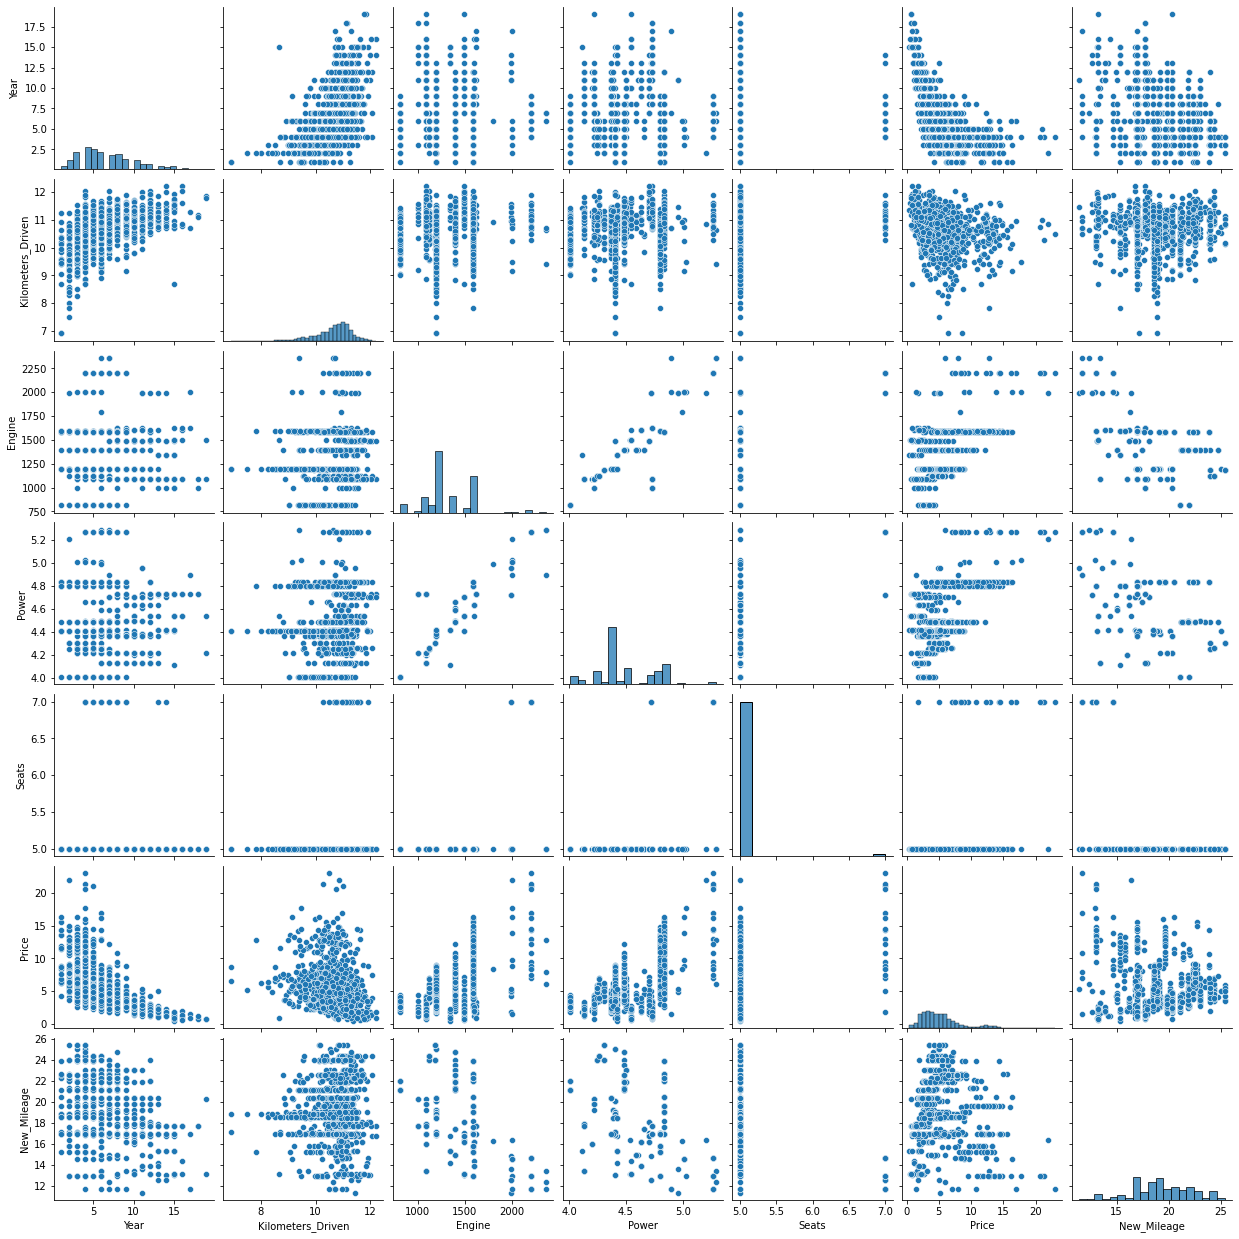

In [15]:
# pairplot
hyundai_numerical = hyundai_df.loc[:,["Year", "Kilometers_Driven", "Engine", "Power", "Seats", "Price", "New_Mileage"]]
sns.pairplot(hyundai_numerical)
plt.show()

In [16]:
#corr.
hyundai_numerical.corr()

,Year,Kilometers_Driven,Engine,Power,Seats,Price,New_Mileage
Year,1.000000,0.521569,-0.036446,0.019272,0.026090,-0.622414,-0.243072
Kilometers_Driven,0.521569,1.000000,0.116980,0.125567,0.092760,-0.260123,0.068901
Engine,-0.036446,0.116980,1.000000,0.898587,0.448252,0.598840,-0.344027
Power,0.019272,0.125567,0.898587,1.000000,0.364780,0.581731,-0.347511
Seats,0.026090,0.092760,0.448252,0.364780,1.000000,0.291964,-0.296919
Price,-0.622414,-0.260123,0.598840,0.581731,0.291964,1.000000,-0.143313
New_Mileage,-0.243072,0.068901,-0.344027,-0.347511,-0.296919,-0.143313,1.000000


현대차만 고려하여 보았을 때,  
Price에 어느정도 영향을 끼치는 변수는  (상관관계계수 0.5 이상)

- **Year**
- **Kilometers_Driven**
- **Engine**
- **Power**

의외로 New_Mileage는 price에 크게 영향을 주지 않음을 알 수 있다.

하지만, 이런 의문이 든다.
Year과 Kilomers_Driven이 과연 정말 차량별로 영향이 가는가에 대해서는 의문이다.

만일 차량별로 이 값이 크게 다르지 않고 Engine, Power만이 영향이 간다면
가격에 대해서는 다음과 같이 회귀 식을 짤 수 있을거 같다.

Y = (Year, Kilmeters_Driven 관련식) + (차량계수) * (Engine, Power 식)

이렇게 4개의 변수에 대해서만 식을 고려하는 것으로 할려고 한다.

이를 위해서 확인해야 하는 가설은 다음과 같다.
- 차량의 브랜드 대비 가격은 다르게 설정된다,
- 차량의 브랜드 대비 engine, power는 다르다.
- (당연히 아니겠지만) 차량의 브랜드 대비 year와 운전거리는 다르다.

이를 위해서는 우선 다시 한번 주어진 데이터 중 차량의 브랜드명을 확인하려고 한다.

In [18]:
df.Name.value_counts()

Maruti           1211
Hyundai          1105
Honda             607
Toyota            411
Volkswagen        313
Mercedes-Benz     299
Ford              284
Mahindra          272
BMW               263
Audi              226
Tata              186
Skoda             170
Renault           145
Chevrolet         121
Nissan             91
Land               55
Jaguar             38
Fiat               28
Mitsubishi         26
Mini               26
Volvo              21
Jeep               15
Datsun             13
Porsche            10
Force               3
ISUZU               2
Smart               1
Ambassador          1
Isuzu               1
Name: Name, dtype: int64

차량별로 건수가 너무 적은거도 있어서 ETC로 묶으려고 하는데, 우선은 이 상태 기준으로 판단하여 차종을 기준으로 묶었을 때, 가격이 정말 달라지는지 통계분석을 한번 실시하려고 한다.

In [33]:
df.groupby('Name')['Price'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
Ambassador,1.0,1.350000,NaN,1.35,1.3500,1.350,1.3500,1.35
Smart,1.0,3.000000,NaN,3.00,3.0000,3.000,3.0000,3.00
Chevrolet,121.0,3.044463,1.827563,0.75,1.7500,2.500,3.7000,9.87
Datsun,13.0,3.049231,0.476156,2.25,2.7000,3.100,3.3100,3.95
Fiat,28.0,3.269286,1.901356,0.55,2.0875,2.600,4.7000,7.71
Tata,186.0,3.562849,2.693689,0.44,1.6950,2.900,4.5800,17.85
Maruti,1211.0,4.517267,2.295684,0.45,2.8000,4.150,5.9950,11.50
Nissan,91.0,4.738352,1.759250,1.75,3.2750,4.300,6.1000,8.92
Volkswagen,313.0,5.280799,2.429335,2.10,3.7500,4.850,6.1500,24.90


가격에 따라 랭크를 나누어서 정리를 하려고 한다.

- S = Jaguar, Land, Porsche
- A = Mini, Mercedes-Benz, Audi, BMW
- B = Isuzu, ISUZU, Jeep, Volvo, Toyota, Mitsubishi, 
     Force, Mahindra
- C = Skoda, Renault, Ford, Honda, Hyundai, volkswagen
- D = Nissan, Maruti, Tata, Fiat, Datsun, Chevrolet, Smart, Ambassador
- ETC는 B로 처리.

이제 이것을 기준으로 하여 랭크를 다시 매기려고 한다.


In [36]:
df['Name'] = df['Name'].replace( ['Jaguar', 'Land', 'Porsche'], 'S')
df['Name'] = df['Name'].replace( ['Mini', 'Mercedes-Benz', 'Audi', 'BMW'], 'A')
df['Name'] = df['Name'].replace( ['Isuzu', 'ISUZU', 'Jeep', 'Volvo', 'Toyota', 'Mitsubishi', 'Force', 'Mahindra'], 'B')
df['Name'] = df['Name'].replace( ['Skoda', 'Renault', 'Ford', 'Honda', 'Hyundai', 'Volkswagen'], 'C')
df['Name'] = df['Name'].replace( ['Nissan', 'Maruti', 'Tata', 'Fiat', 'Datsun', 'Chevrolet', 'Smart', 'Ambassador'], 'D')

In [42]:
df.groupby('Name')['Price'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
D,1652.0,4.278571,2.325055,0.44,2.5000,3.85,5.7500,17.85
C,2624.0,5.536993,3.335808,0.45,3.3500,4.90,6.7225,32.90
B,751.0,10.634754,6.365633,1.00,5.7500,9.25,14.4250,35.82
A,814.0,25.557015,13.996057,3.90,15.0525,23.00,32.5150,93.67
S,103.0,38.309320,20.830346,11.00,25.8500,34.50,45.0000,160.00


## 4. 회귀분석 시도 및 문제점 고찰

아쉽게도, **집단별로 분산이 달라서 분산분석은 사용하기 어려울 듯 하다**.
대신에 S, A, B, C, D 별로 모델링을 하여 가격이 얼마나 정확하게 나올지를 검토해보고 싶다. 그럼 이제 실제로 선형회귀분석을 진행하고자 한다.
그리고 그에 대한 계수 결과가 내가 예측한 대로 나오는지에 대해서도 검토를 해보려고 한다. 그 전에, 하나의 클래스를 골라서 다시 상관계수를 검토해보려고 한다.

In [43]:
# C 클래스만만 추출,
cclass_df = df.loc[df.Name=="C",:]
cclass_df = cclass_df.reset_index()
cclass_df = cclass_df.drop('index', axis = 1)
cclass_df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,New_Mileage
0,C,Pune,5,10.621327,Diesel,Manual,1,1582.0,4.837868,5.0,12.50,19.67
1,C,Chennai,9,10.736397,Petrol,Manual,1,1199.0,4.485260,5.0,4.50,18.20
2,C,Hyderabad,8,11.225243,LPG,Manual,1,814.0,4.010963,5.0,2.35,21.10
3,C,Pune,7,11.073335,Diesel,Manual,1,1598.0,4.640537,5.0,5.20,20.54
4,C,Kolkata,8,11.002100,Petrol,Automatic,1,1497.0,4.756173,5.0,4.49,16.80


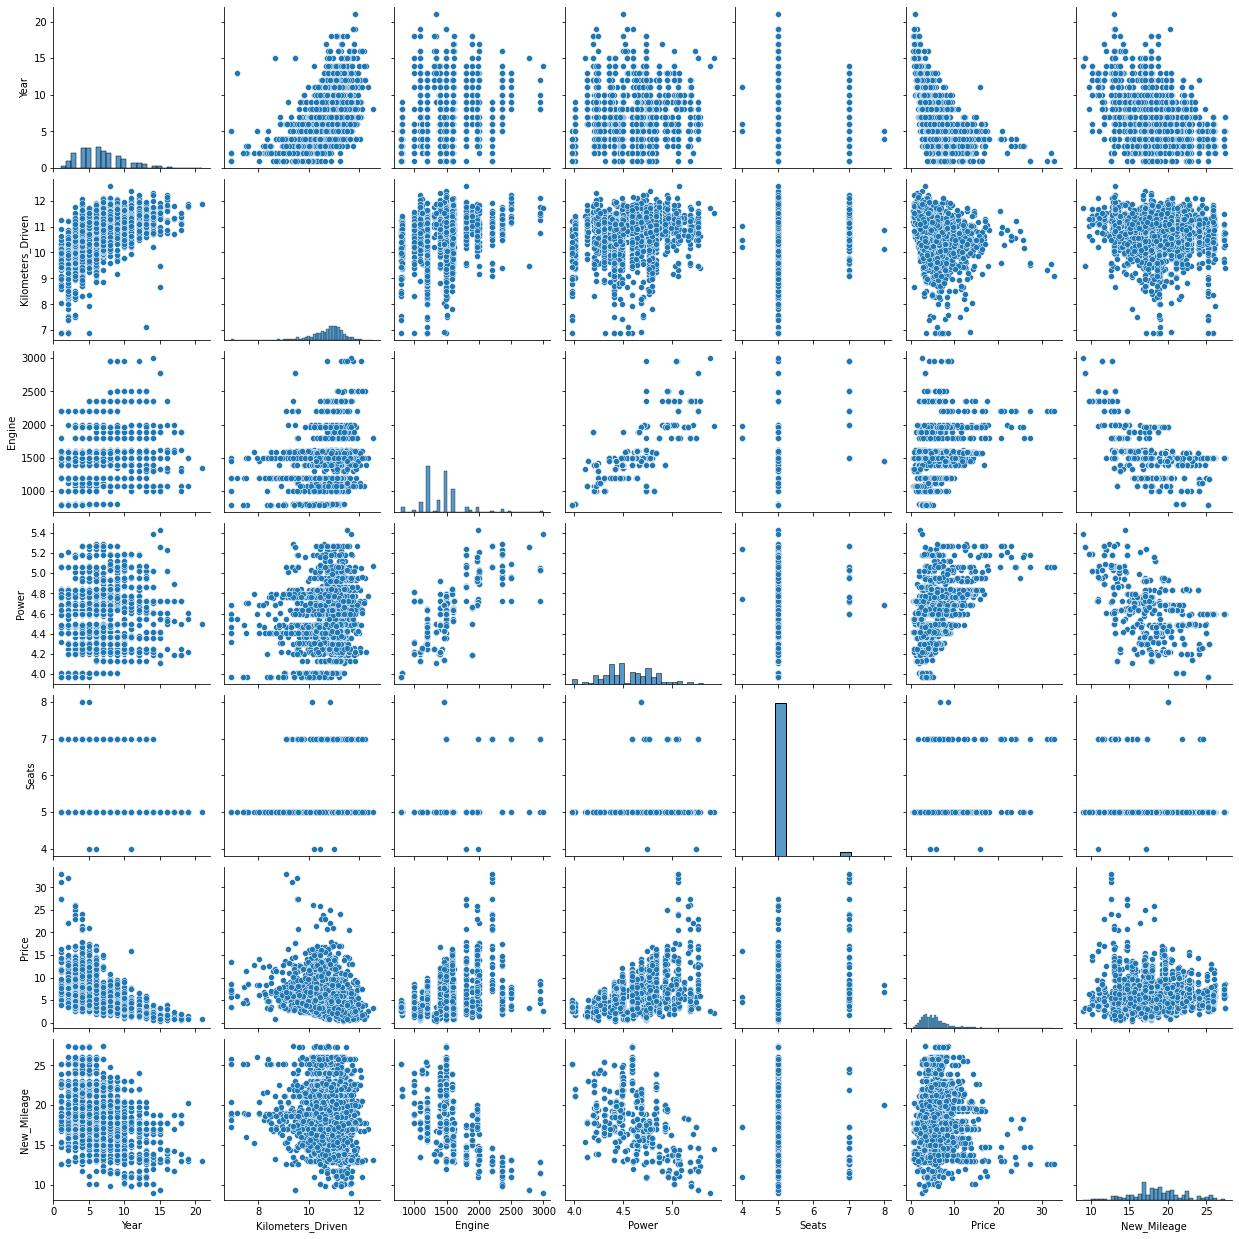

In [44]:
# pairplot
c_numerical = cclass_df.loc[:,["Year", "Kilometers_Driven", "Engine", "Power", "Seats", "Price", "New_Mileage"]]
sns.pairplot(c_numerical)
plt.show()

In [45]:
c_numerical.corr()

,Year,Kilometers_Driven,Engine,Power,Seats,Price,New_Mileage
Year,1.000000,0.530040,0.199996,0.070598,-0.015387,-0.576432,-0.350651
Kilometers_Driven,0.530040,1.000000,0.262356,0.140749,0.030731,-0.269490,-0.055141
Engine,0.199996,0.262356,1.000000,0.810678,0.316768,0.395403,-0.414400
Power,0.070598,0.140749,0.810678,1.000000,0.228481,0.507594,-0.401570
Seats,-0.015387,0.030731,0.316768,0.228481,1.000000,0.234211,-0.151006
Price,-0.576432,-0.269490,0.395403,0.507594,0.234211,1.000000,-0.073161
New_Mileage,-0.350651,-0.055141,-0.414400,-0.401570,-0.151006,-0.073161,1.000000


접근에 조금 문제가 생긴 듯 하다. 하나의 Class에 대해 묶어버린 결과, 오히려 일부 상관계수 값이, 특히 Engine과 Power에 큰 문제가 생긴 듯 하다.

이게 어떻게 된 일인지 확인하고자 세 가지 상황을 비교해보고 문제점을 분석하려고 한다.

- C class 전체를 기준으로 한 선형회귀모델의 생성
- C class 중 하나의 차종에 대해서만 선형회귀모델의 생성
- 아예 차종 Name을 무시하고 선형회귀모델의 생성

In [51]:
# Case 1, C Class 전체.
import statsmodels.api as sm
from sklearn.datasets import make_regression

# 1-1 Data set 준비
cclass_X = cclass_df.loc[:,["Year", "Kilometers_Driven", "Power"]]
cclass_y = cclass_df.loc[:, "Price"]

cc_reg = pd.concat([cclass_X, cclass_y], axis=1)
cc_reg.tail()

# 1-2 회귀분석
dfy = cclass_y
dfX = sm.add_constant(cclass_X)
model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

# 정확도 65.2% ㅠㅠㅠㅠ
# 한편 계수상, Engine이 너무 작게 나오고 Cond. NO를 너무 높여문제가 발생하길래 일단은 제외.
# 63.5% ㅠㅠㅠ

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     1519.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:33:52   Log-Likelihood:                -5561.6
No. Observations:                2624   AIC:                         1.113e+04
Df Residuals:                    2620   BIC:                         1.115e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -21.2918      0.91

In [50]:
# 2-1 Data set 준비
hyundai_X = hyundai_df.loc[:,["Year", "Kilometers_Driven", "Power"]]
hyundai_y = hyundai_df.loc[:, "Price"]


# 2-2 회귀분석
dfy = hyundai_y
dfX = sm.add_constant(hyundai_X)
model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

# 73.9%.. 뭔가 좀 아쉽다.

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1045.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):          1.74e-321
Time:                        14:33:22   Log-Likelihood:                -2146.8
No. Observations:                1105   AIC:                             4302.
Df Residuals:                    1101   BIC:                             4322.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -24.6313      1.18

In [52]:
# 3-1 Data set 준비
df_X = df.loc[:,["Year", "Kilometers_Driven", "Power"]]
df_y = df.loc[:, "Price"]

# 3-2 회귀분석
dfy = df_y
dfX = sm.add_constant(df_X)
model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

# 57.6%.. 뭔가 좀 아쉽다.

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     2694.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:35:42   Log-Likelihood:                -19851.
No. Observations:                5944   AIC:                         3.971e+04
Df Residuals:                    5940   BIC:                         3.974e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -54.6387      1.72

3가지를 비교해 본 결과, 차량 한 종을 지정했을 경우에 정확도가 가장 높음을 알 수 있다. 하지만 위의 내용을 참고하면 차량이 1~2종만 있는 경우도 꽤 있어 **차량 단위별로 모두 회귀직선을 만드는 것은 크게 의미도 없고 노가다만 하는 것으로 보인다.**

어느정도 타협을 하면, Class 단위별로 5개의 모델을 만들어 특정 브랜드의 차량이 들어오면 등급이 어느정도고, 나머지 변수에 따라 최종 결론을 내는 방식을 진행할 수 있어보인다. ** 물론, 얼마나 class를 정밀하게 나누냐에 따라 달라지겠지만 말이다.**

아무튼, C class에 대한 회귀직선은 (약간의 변수 변환을 한 상태 기준으로) 얻어냈다.

문제점과 부족한 점을 많이 느낀 상황이다.

(1) 어느 변수가 어떻게 중요한지, 어떤 계수로 적용되는지를 정확하게 구할 필요가 있어보인다.  -> **주성분 분석**등을 통해 Cond. No.를 그냥 감으로 줄이는 것이 아니라, 정확한 근거를 가지고 줄여봐야 하겠다.

(2) 변수에 대한 전처리의 정밀성이 부족해 보인다.
어떤 변수를 어떻게 전처리를 해야할지, 특히 Name의 경우 그냥 평균을 계산하고 대치를 막 한 감이 있는데, 실제로 분포를 보면 낮은 클래스의 최대값이 높은 클래스의 최소값보다 작은 분포가 겹치는 상황이 발생한다. -> **전처리의 방법과 근거에 대한 추가 학습이 필요**

(3) 분포에 대한 검증이 부족해보인다.
실제로 분산분석을 하려고 하다보니, 정규성/동질성 검증이 부족하여 올바른 Name 분류에 실패한 것으로 보인다. -> **분포의 검정에 대해서 학습할 것**

**맨 처음으로** 무언가 분석을 시도해보았는데, 러프하게 무언가 될거 같은데 이후의 진도를 뽑지 못한 느낌이 들어, 일단은 부족한 부분을 메꾸고 추후에 다시 분석을 시도할 주제이다. 

2~3월달에 **Re-visited**에서 다시 만나기로 하자.
얼마나 성장해있을지 궁금하다.